In [1]:
import glob, pandas, uproot, matplotlib, re, math
import numpy as np
from gap_statistic import OptimalK
from plotParams import varLabels, binnings, units
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

randomState = 5
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [37]:
path='/data/atlasfs02/a/users/whopkins/ccMET/'
rTag = 'r10724*'
# Need to add year weight somehow and need to make sure to concetenate signals
#rTag = ''
paths = glob.glob(path+f'*{rTag}.root')
sigPaths = [path for path in paths if 'TT_mixedTC' in path]
bkgPaths = [path for path in paths if 'TT_mixedTC' not in path and 'mc16_13TeV.364' not in path and 'Sherpa_221_' not in path and 'mc16' in path]
treeName='Nominal'

# Only select variables that were used in the original signal regions.
from ccMET_selections import selections
srList = ['SRA']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_2jet')
branches.append('pT_1cjet')
branches.append('pT_2cjet')
branches.append('RunNumber')
branches.append('LumiWeight')
branches.append('AnalysisWeight')

#print(branches) 
allSampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'mixedTC_';
    secondSplitStr = '.'
    allSampLabels.append('sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0].replace('_MET100', ''))

dataList = []
lumi = 139000
# This is needed due to memory constraints, I think...
nSigEvents = 1000
sigData = {}
nSigs = 80
chosenPaths = sigPaths#[:nSigs]
minNEvents = 100
sampLabels = []
for path, sampName in zip(sigPaths, allSampLabels):
    #if '27_' in sampName or '77_' in sampName or '62_' in sampName or '12_' in sampName:
    #    continue
    stopMass, lspMass = [int(mass) for mass in sampName.split('_')[1:3]]
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, library='pd')
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi*4
    if data.shape[0] < minNEvents or data.weight.sum() < 1E-4:
        print(sampName, 'had few events.')
        continue
    data['sampName'] = sampName
    sigData[sampName] = data
    # if data.shape[0] < nSigEvents:
    #     sigData[sampName] = data
    # else:
    #     sigData[sampName] = data.sample(n=nSigEvents)
    sampLabels.append(sampName)

bkgData = []
weights = []
for path in bkgPaths:
    fName = path.split('/')[-1]
    sampName = fName.split('.')[2]
    inF = uproot.open(path)
    tree = inF[treeName]
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data = tree.arrays(branches, library='pd')
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    data['sampName'] = 'bkg'
    bkgData.append(data)
dataList = list(sigData.values())
dataList.extend(bkgData)

allSamps = pandas.concat(dataList)
sampLabels.append('bkg')
print(sorted(sampLabels))

['bkg', 'sig_1000_1', 'sig_1000_100', 'sig_1000_200', 'sig_1000_300', 'sig_1000_400', 'sig_1000_500', 'sig_1000_600', 'sig_1000_700', 'sig_1050_150', 'sig_1050_250', 'sig_1050_50', 'sig_1100_1', 'sig_1100_100', 'sig_1100_200', 'sig_1100_300', 'sig_1100_400', 'sig_1100_500', 'sig_1100_600', 'sig_1100_700', 'sig_1200_1', 'sig_1200_100', 'sig_1200_200', 'sig_1200_300', 'sig_1200_400', 'sig_1200_500', 'sig_1200_600', 'sig_1300_1', 'sig_1300_100', 'sig_1300_200', 'sig_1300_300', 'sig_1300_400', 'sig_1300_500', 'sig_400_225', 'sig_500_1', 'sig_500_325', 'sig_550_375', 'sig_600_1', 'sig_600_300', 'sig_600_425', 'sig_650_350', 'sig_650_475', 'sig_700_1', 'sig_700_100', 'sig_700_200', 'sig_700_300', 'sig_700_400', 'sig_700_525', 'sig_750_250', 'sig_750_350', 'sig_750_450', 'sig_750_575', 'sig_800_1', 'sig_800_100', 'sig_800_200', 'sig_800_300', 'sig_800_400', 'sig_800_500', 'sig_800_625', 'sig_850_150', 'sig_850_250', 'sig_850_350', 'sig_850_450', 'sig_850_50', 'sig_900_1', 'sig_900_100', 'sig_

In [38]:
presel = selections['presel_0lep_1cjet20'].replace('*', ' & ').replace('||', ' | ').replace('(', '(allSamps.').replace('allSamps.(', '(')
print(presel)
#print(sorted(branches))
myPresel = (allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=2)

(allSamps.passTightCleanDFFlag==1) & (allSamps.nj_good>=2) & ((allSamps.tcMeTCategory==1) | (allSamps.tcMeTCategory<0)) & (allSamps.pT_1jet>250) & (allSamps.num_bjets==0) & ((allSamps.GenFiltMET<100 ) |  (allSamps.RunNumber!=410470)) & (allSamps.METTrigPassed) & (allSamps.nsignalLep==0) & (allSamps.nbaselineLep==0) & (allSamps.eT_miss>250) & (allSamps.minDPhi_4jetMET>0.4) & (allSamps.num_cjets20>=1)


In [39]:
rawDataPresel = allSamps[eval(presel)].copy()
#rawDataPresel = allSamps[myPresel].copy()
sampSizes = {}
sampYields = {}
print(len(set(sampLabels)))

for sampName in sorted(pandas.unique(rawDataPresel.sampName)):
    sampIndex = rawDataPresel['sampName']==sampName
    sampYield = rawDataPresel[sampIndex].weight.sum()
    if sampYield == 0:
        print("Dropping", sampName)
        rawDataPresel.drop(sampIndex)
    sampSizes[sampName] = rawDataPresel[sampIndex].shape[0]
    sampYields[sampName] = sampYield
    print(sampName, round(sampYield,1), sampIndex.sum())
    
maxYieldKey = max(sampYields, key=lambda k: sampYields[k])
tempDFs = []
goodSamps = pandas.unique(rawDataPresel.sampName)
for sampName in sampYields:
    sampIndex = rawDataPresel['sampName']==sampName
    rawDataPresel.loc[sampIndex, 'clus_weight'] = rawDataPresel.loc[sampIndex, 'weight']*(sampYields[maxYieldKey]/sampYields[sampName])
    #print(rawDataPresel[sampIndex].clus_weight.sum())

75
bkg 46728.0 89344
sig_1000_1 156.1 426
sig_1000_100 167.2 455
sig_1000_200 177.7 482
sig_1000_300 168.6 458
sig_1000_400 160.7 439
sig_1000_500 156.6 433
sig_1000_600 138.0 387
sig_1000_700 118.6 339
sig_1050_150 111.8 433
sig_1050_250 113.0 437
sig_1050_50 108.4 419
sig_1100_1 79.9 440
sig_1100_100 71.4 394
sig_1100_200 71.2 392
sig_1100_300 79.8 445
sig_1100_400 76.7 419
sig_1100_500 87.1 477
sig_1100_600 80.1 446
sig_1100_700 69.5 392
sig_1200_1 38.7 414


sig_1200_100 35.5 388
sig_1200_200 38.5 417
sig_1200_300 38.7 419
sig_1200_400 39.9 431
sig_1200_500 39.3 425
sig_1200_600 43.0 470
sig_1300_1 19.4 401
sig_1300_100 20.3 420
sig_1300_200 17.6 358
sig_1300_300 19.8 407
sig_1300_400 20.0 409
sig_1300_500 20.7 430
sig_400_225 7185.3 451
sig_500_1 8643.6 1410
sig_500_325 2524.6 525
sig_550_375 1548.6 1099
sig_600_1 3803.6 1751
sig_600_300 2521.3 1206
sig_600_425 1056.3 629
sig_650_350 1622.3 1295
sig_650_475 624.0 593
sig_700_1 1667.1 2028
sig_700_100 1665.1 2017
sig_700_200 1531.5 1868


sig_700_300 1432.7 1773
sig_700_400 1080.1 2745
sig_700_525 403.3 483
sig_750_250 1080.9 1229
sig_750_350 938.2 1078
sig_750_450 686.1 811
sig_750_575 285.4 396
sig_800_1 748.8 860
sig_800_100 688.6 792
sig_800_200 736.5 841
sig_800_300 727.1 843
sig_800_400 658.0 777
sig_800_500 448.8 543
sig_800_625 195.0 276
sig_850_150 496.9 858
sig_850_250 482.7 836
sig_850_350 462.9 810
sig_850_450 407.4 723
sig_850_50 511.4 836
sig_900_1 333.2 4281
sig_900_100 341.5 438
sig_900_200 342.8 439
sig_900_300 310.3 404
sig_900_400 314.2 409


sig_900_500 279.5 367
sig_900_600 206.0 278
sig_950_150 206.4 384
sig_950_250 214.6 403
sig_950_350 223.6 423
sig_950_50 229.8 430


In [40]:
vetoList=['GenFiltMET', 'METTrigPassed', 'nsignalLep', 'num_cjets20', 'passTightCleanDFFlag', 'tcMeTCategory', 'RunNumber', 'LumiWeight', 'AnalysisWeight']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
# Tried adding more variables but this seems to cause a degradation in performance: only one signal cluster is found.
# (two are expected based on the manually designed signal regions).
trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1jet', 'pT_2jet']#, 'pT_1cjet', 'pT_2cjet']# 'eT_miss']
#trainBranches = ['MTcMin20', 'metsigST', 'm_cc20', 'pT_1cjet', 'pT_2cjet']#, 'eT_miss']
varListStr = '_'.join(trainBranches)
print(varListStr)
prettySampNames = {
    'bkg':'SM Background',
}
for sampNum, sampName in enumerate(sampLabels):
    if 'sig' in sampName:
        stopMass, lspMass = sampName.split('_')[1:3]
        #prettySampNames[samp] = '$m_{\\tilde{t}}, m_{\\chi}$='+stopMass+', '+lspMass+' GeV'
        prettySampNames[sampName] = f'SUSY model {sampNum+1}' 

['MTcMin20', 'eT_miss', 'm_cc20', 'metsigST', 'minDPhi_4jetMET', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_1jet', 'pT_2jet', 'pT_1cjet', 'pT_2cjet']
MTcMin20_metsigST_m_cc20_pT_1jet_pT_2jet


In [41]:
scaledData = rawDataPresel.copy(deep=True)
scalers = {}
for column in trainBranches:
    print(column)
    scalers[column] = MinMaxScaler()
    scaledData[[column]] = scalers[column].fit_transform(scaledData[[column]])
clusteringData = scaledData[trainBranches]

MTcMin20
metsigST
m_cc20
pT_1jet
pT_2jet


In [42]:
twoSigs = scaledData[(scaledData.sampName=='sig_1300_1') | ( scaledData.sampName=='sig_550_375')]
bkgs = scaledData[(scaledData.sampName=='bkg')].sample(1000)
# aeData = bkgs[trainBranches]
# weights = bkgs['clus_weight']
aeData = twoSigs[trainBranches]
weights = twoSigs['clus_weight']
print(aeData.shape)

(1500, 5)


In [43]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

latent_dim = 2

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(len(trainBranches), activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [44]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [45]:
testTrainFrac = 0.5
nEvents=aeData.shape[0]
msk = np.random.choice(nEvents, int(nEvents*testTrainFrac), replace=False)
xTrain = aeData.to_numpy()[msk]
xTest = aeData.to_numpy()[~msk]
trainWeights = weights.to_numpy()[msk]
testWeights = weights.to_numpy()[~msk]

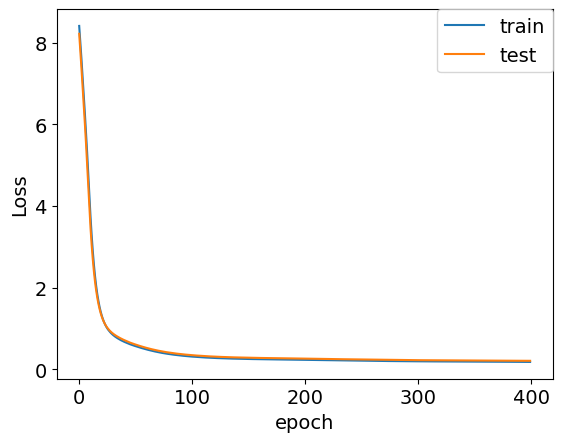

In [46]:
history = autoencoder.fit(xTrain,xTrain,
                          sample_weight=trainWeights,
                          epochs=400,
                          shuffle=True,
                          #validation_data=(xTest, xTest),
                          validation_data=(xTest, xTest, testWeights),
                          verbose=False
                          )
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
leg = plt.legend(['train', 'test'], loc=0, borderaxespad=0.)
plt.savefig('loss.pdf', bbox_inches='tight')

In [59]:
encoded = {}
decoded = {}
for sampName in sorted(sorted(pandas.unique(twoSigs.sampName))):
    tempData = twoSigs[twoSigs.sampName==sampName][trainBranches]
    encoded[sampName] = autoencoder.encoder(tempData.to_numpy()).numpy()
    decoded[sampName] = autoencoder.decoder(encoded[sampName]).numpy()

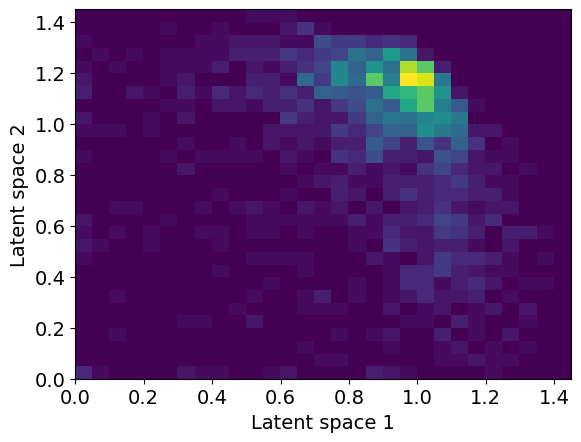

In [60]:
# This shows the latent spacce distributions for the two signals. Essentially we have trained a unsupervised
# classifier since labels were not given to the NN. The latent space is overly simple here (1D).
# We can applying clustering to this latent space and avoid high dimensionality and essentially
# summarize low-level variables. A variational auto-encoder would make these nice Gaussians at which point
# we may be able to use model-based clustering (k-means will also work).
fig, ax = plt.subplots()
bins2d = [[i*.05 for i in range(30)], [i*.05 for i in range(30)]]
colors=['k','r']
totalEncodedDist = autoencoder.encoder(twoSigs[trainBranches].to_numpy()).numpy()
a = plt.hist2d(totalEncodedDist[:,0], totalEncodedDist[:,1], bins=bins2d,)
ax.set_xlabel('Latent space 1')
ax.set_ylabel('Latent space 2')
plt.savefig(f'latentSpace.pdf', bbox_inches='tight')
plt.savefig(f'latentSpace.svg', bbox_inches='tight')
plt.savefig(f'latentSpace.png', bbox_inches='tight')

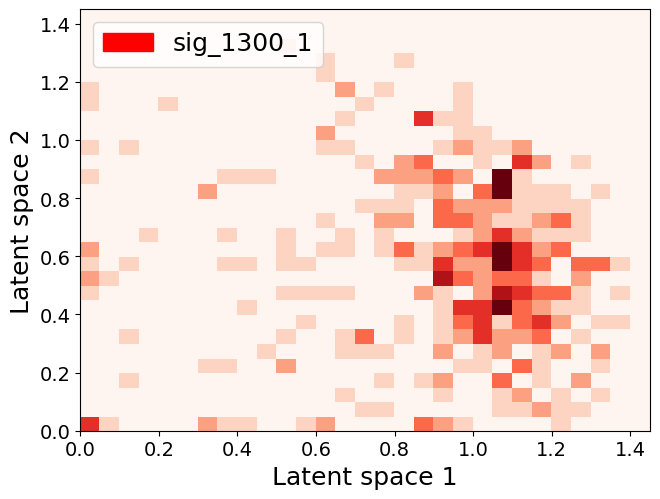

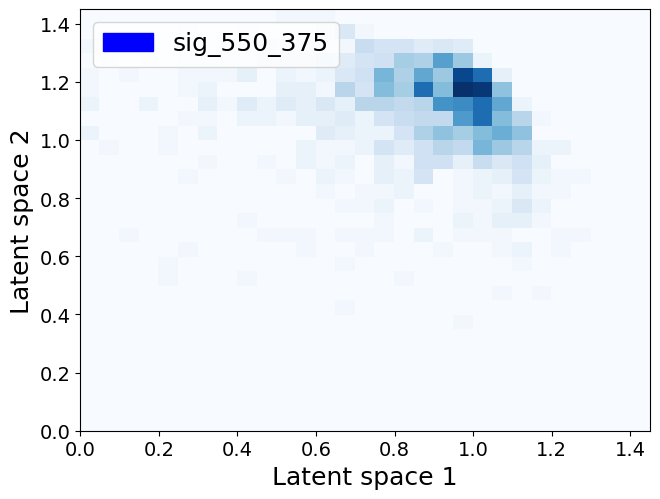

In [64]:
colorMaps = [plt.cm.Reds, plt.cm.Blues]#, plt.cm.Greys]
colors = ['r', 'b']
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fontsize=8
for color, cmap, sampLabel in zip(colors, colorMaps, sorted(encoded.keys())):
    fig, ax = plt.subplots()
    plt.hist2d(encoded[sampLabel][:,0], encoded[sampLabel][:,1], bins=bins2d, cmap=cmap, label=sampLabel)#, weights=sampData.weight)
    #plt.contour(xx, yy, z, levels=3, colors='g', linewidths=[3])
    #cluster1Text = ax.text(0.15, 0.05, 'Cluster 1', ha="center", va="center", color=sampColors[2], fontsize=20)
    #cluster2Text = ax.text(0.8, 0.05, 'Cluster 2', ha="center", va="center", color=sampColors[1], fontsize=20)
    #cluster3Text = ax.text(0.15, 0.8, 'Cluster 3', ha="center", va="center", color=sampColors[0], fontsize=20)
    legHandles = [mpatches.Patch(color=color, label=sampLabel)]

    #ax.set_ylim(0, 1)
    #ax.set_xlim(0, 1)
    fontsize=18
    ax.set_xlabel('Latent space 1', fontsize=fontsize)
    ax.set_ylabel('Latent space 2', fontsize=fontsize)
    ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=2)
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"latentSpace_{sampLabel}_2DHist.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"latentSpace_{sampLabel}_2DHist.pdf",bbox_inches='tight', pad_inches=0)